In [41]:
import pandas as pd

df = pd.read_csv("G:/My Drive/Data-Centric Solutions/07. Blog Posts/kedro/data/creditcard.csv")

In [42]:
df['transaction_id'] = df.index

In [43]:
df['Class'].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

In [44]:
import glob
import os

def delete_file():
    # Get a list of all HDF5 files in the current directory
    hdf5_files = glob.glob('*.hdf5')

    # Print each HDF5 file name
    for file in hdf5_files:
        os.remove(file)

    # Get a list of all JSON files in the current directory
    json_files = glob.glob('*.json')

    # Print each JSON file name
    for file in json_files:
        os.remove(file)
        
def get_latest_experiment_dir(base_dir):
        # Get a list of all items in the base directory
        items = os.listdir(base_dir)

        # Filter out items that are not directories
        dirs = [item for item in items if os.path.isdir(os.path.join(base_dir, item))]

        # Filter out directories that do not start with 'experiment_run'
        experiment_dirs = [dir for dir in dirs if dir.startswith('experiment_run')]

        # Sort the directories by the experiment number (the part after 'experiment_run')
        sorted_experiment_dirs = sorted(experiment_dirs, key=lambda dir: int(dir.split('_')[-1]) if dir.split('_')[-1].isdigit() else -1)

        # Return the last directory in the sorted list
        latest_dir = sorted_experiment_dirs[-1] if sorted_experiment_dirs else None
        
        # If latest_dir is None, raise an error
        if latest_dir is None:
            raise ValueError(f"No directories starting with 'experiment_run' found in {base_dir}")
        
        # Return the full path of the latest directory
        return os.path.join(base_dir, latest_dir).replace('\\', '/') if latest_dir else None

In [45]:
from sdv.metadata import SingleTableMetadata
def create_metadata(df):
    df_fraud = df.loc[df["Class"] == 1]
    df_fraud.head(5)
    metadata = SingleTableMetadata()
    metadata.detect_from_dataframe(data=df_fraud)

    metadata.update_column(
        column_name='transaction_id',
        sdtype='id')

    # set primary key 
    metadata.set_primary_key(column_name='transaction_id')
    metadata.validate()
    return metadata, df_fraud

In [46]:
import warnings
import numpy as np
from sdv.single_table import TVAESynthesizer
# from sdv.single_table import CTGANSynthesizer

def create_synthetic_data(df, samples):
    warnings.filterwarnings('ignore', category=FutureWarning)
    
    metadata, df_fraud = create_metadata(df)

    synthesizer = TVAESynthesizer(
        metadata, # required
        enforce_min_max_values=True,
        enforce_rounding=False,
        epochs=2000
    )
    synthesizer.fit(df_fraud)

    synthetic_data = synthesizer.sample(num_rows=samples)
    synthetic_data['Time'] = np.round(synthetic_data['Time'])
    
    return synthetic_data

In [47]:
from sdv.evaluation.single_table import evaluate_quality
from sdmetrics.warnings import ConstantInputWarning

def quality_check(real_data, synthetic_data):
    warnings.simplefilter(action='ignore', category=ConstantInputWarning)
    quality_report = evaluate_quality(
        real_data=real_data,
        synthetic_data=synthetic_data,
        metadata=metadata)

In [48]:
from sdv.evaluation.single_table import get_column_plot

def plot_dists(real_data, synthetic_data, column_name):
    fig = get_column_plot(
        real_data=real_data,
        synthetic_data=synthetic_data,
        column_name=column_name,
        metadata=metadata
    )

    fig.show()


In [49]:
from sklearn.model_selection import train_test_split

def split_data(df, synthetic_data):

    train, holdout_df = train_test_split(df, test_size=0.2, random_state=42)
    
    synthetic_data = create_synthetic_data(df=train, samples=283823)
    
    train_with_synth = pd.concat([train, synthetic_data], ignore_index=True) 
    
    return train, train_with_synth, holdout_df


In [50]:
from ludwig.api import LudwigModel
import requests
import yaml


# URL of the raw YAML file in the GitHub repository
def run_experiment(url, train_df, output_dir):
    url = url

    # Send a GET request to the URL
    response = requests.get(url)

    # Raise an exception if the request was unsuccessful
    response.raise_for_status()

    # Load the YAML data from the response text
    config = yaml.safe_load(response.text)

    # Set up your experiment
    model = LudwigModel(config=config)
    experiment_results = model.experiment(
      dataset=train_df,
      output_directory=output_dir
    )
    return model

In [51]:
def analysis(model, holdout_df):
    holdout_df = holdout_df.reset_index(drop=True)
    predictions, _ = model.predict(dataset=holdout_df)

    model_analysis_df = predictions.merge(right=holdout_df, left_index=True, right_index=True)
    model_analysis_df['Class_predictions'] = model_analysis_df['Class_predictions'].map({True: 1, False: 0})
    return model_analysis_df

In [52]:
import plotly.graph_objects as go
from sklearn.metrics import precision_recall_curve, auc
import numpy as np

def model_diagnostics(model_analysis_df, title):
    # Calculate Precision-Recall curve
    precision, recall, thresholds = precision_recall_curve(model_analysis_df['Class'], model_analysis_df['Class_predictions'])
    pr_auc = auc(recall, precision)

    # Calculate F1 scores for each threshold
    f1_scores = 2*(recall * precision) / (recall + precision)
    # Get index of the maximum F1 score
    max_f1_index = np.argmax(f1_scores)
    max_f1 = f1_scores[max_f1_index]
    max_precision = precision[max_f1_index]
    max_recall = recall[max_f1_index]

    # Create the Precision-Recall curve
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=recall, y=precision,
                             mode='lines',
                             name=f'PR curve (AUC = {pr_auc:.2f})'))

    # Mark the point with maximum F1 score
    fig.add_trace(go.Scatter(x=[max_recall], y=[max_precision],
                             mode='markers',
                             marker=dict(color='Red', size=10),
                             name=f'Max F1 ({max_f1:.2f})'))

    # Add annotation for precision and recall at max F1 score
    fig.add_annotation(x=max_recall, y=max_precision,
                       text=f'Precision: {max_precision:.2f}, Recall: {max_recall:.2f}',
                       showarrow=True,
                       arrowhead=1,
                       ax=0,
                       ay=-80)

    # Add random line
    no_skill = len(model_analysis_df['Class'][model_analysis_df['Class']==1]) / len(model_analysis_df['Class'])
    fig.add_trace(go.Scatter(x=[0, 1], y=[no_skill, no_skill],
                             mode='lines', 
                             name='No Skill', 
                             line=dict(dash='dash')))

    fig.update_xaxes(title_text="Recall")
    fig.update_yaxes(title_text="Precision", range=[0, 1])
    fig.update_layout(title_text=title, autosize=False)

    fig.show()

    # Return AUC and the values for the highest corner
    return pr_auc, max_f1, max_precision, max_recall


In [53]:
import json
def plot_loss(output_dir):
    
    latest_experiment_dir = get_latest_experiment_dir(output_dir)

    json_path = latest_experiment_dir + "/training_statistics.json"

    # Load the JSON file
    with open(json_path, 'r') as f:
        train_stats = json.load(f)

    train_loss = train_stats['training']['Class']['loss']
    validation_loss = train_stats['validation']['Class']['loss']
    test_loss = train_stats['test']['Class']['loss']

    # Create list of epochs
    epochs = list(range(1, len(train_loss) + 1))

    # Create the plot
    fig = go.Figure()

    # Add traces
    fig.add_trace(go.Scatter(x=epochs, y=train_loss, mode='lines', name='Training loss'))
    fig.add_trace(go.Scatter(x=epochs, y=validation_loss, mode='lines', name='Validation loss'))
    fig.add_trace(go.Scatter(x=epochs, y=test_loss, mode='lines', name='Test loss'))

    # Add details
    fig.update_layout(title='Training, Validation and Test Loss', xaxis_title='Epochs', yaxis_title='Loss')
    
    fig.show()
    
    loss_plot = fig
    

In [54]:
# Create datasets
train, train_with_synth, holdout_df = split_data(df, synthetic_data)

Detected metadata:
{
    "METADATA_SPEC_VERSION": "SINGLE_TABLE_V1",
    "columns": {
        "Time": {
            "sdtype": "numerical"
        },
        "V1": {
            "sdtype": "numerical"
        },
        "V2": {
            "sdtype": "numerical"
        },
        "V3": {
            "sdtype": "numerical"
        },
        "V4": {
            "sdtype": "numerical"
        },
        "V5": {
            "sdtype": "numerical"
        },
        "V6": {
            "sdtype": "numerical"
        },
        "V7": {
            "sdtype": "numerical"
        },
        "V8": {
            "sdtype": "numerical"
        },
        "V9": {
            "sdtype": "numerical"
        },
        "V10": {
            "sdtype": "numerical"
        },
        "V11": {
            "sdtype": "numerical"
        },
        "V12": {
            "sdtype": "numerical"
        },
        "V13": {
            "sdtype": "numerical"
        },
        "V14": {
            "sdtype": "numerical"
   

Creating report: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:29<00:00,  7.42s/it]



Overall Quality Score: 93.3%

Properties:
Column Shapes: 91.37%
Column Pair Trends: 95.24%


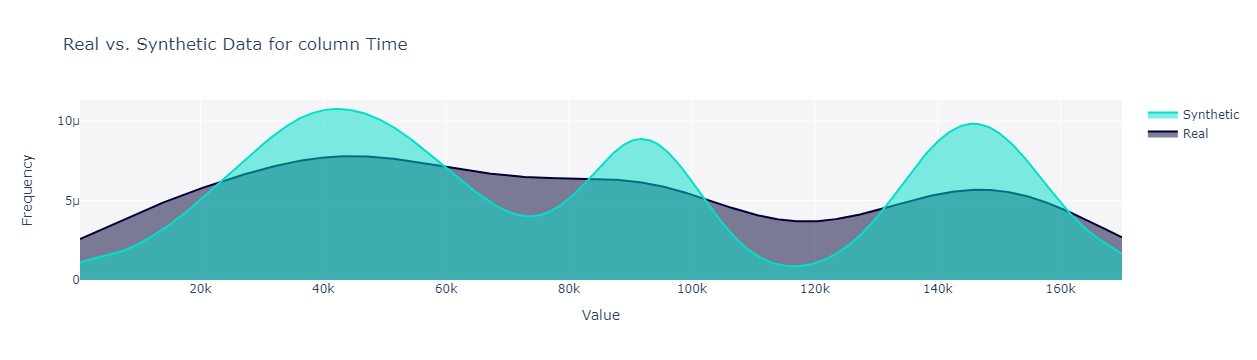

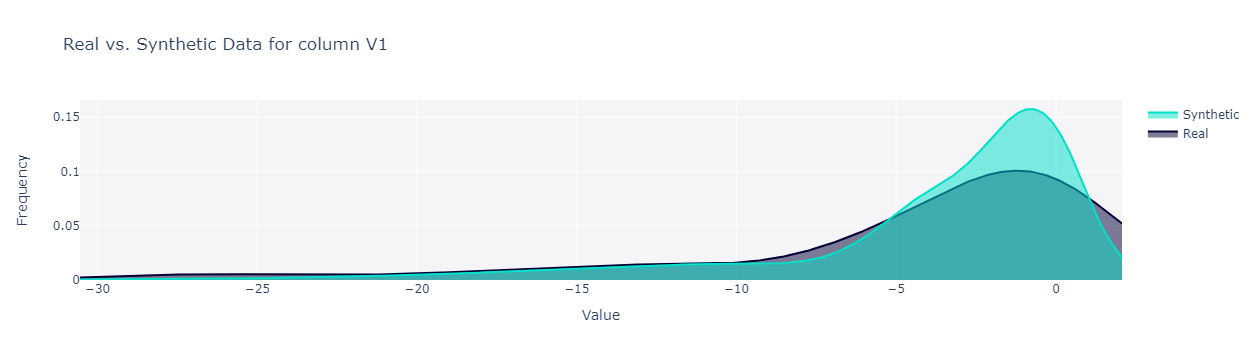

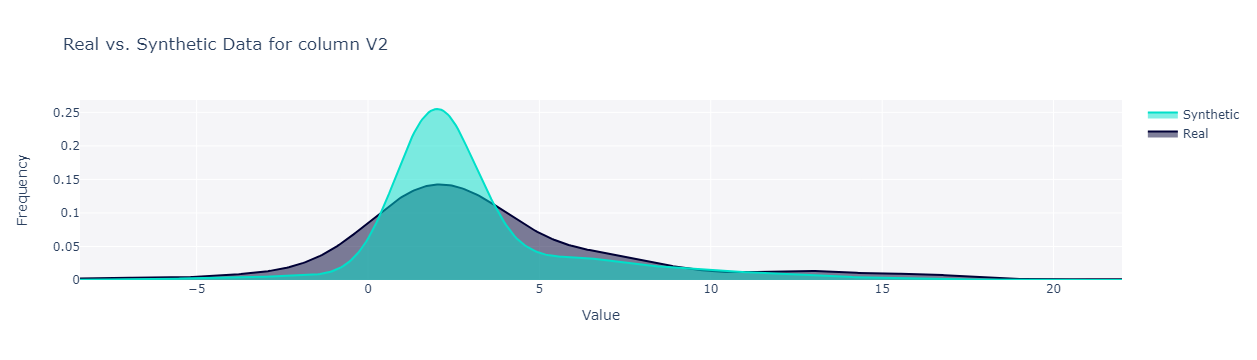

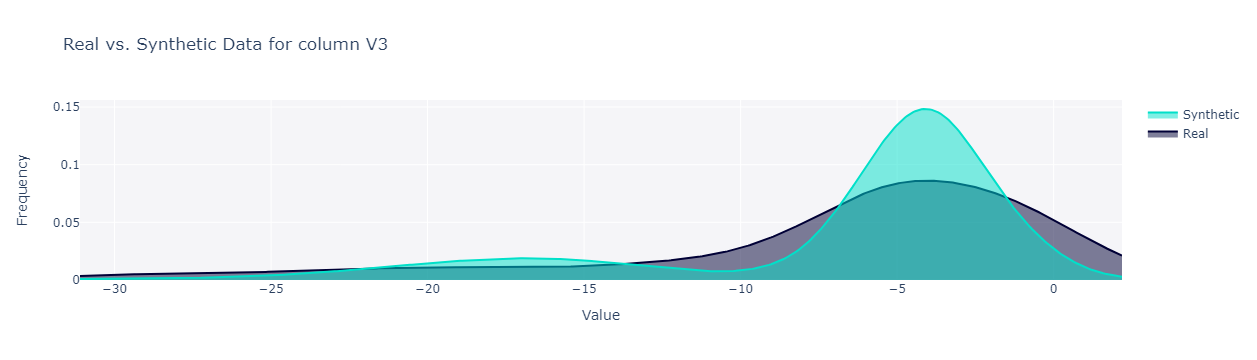

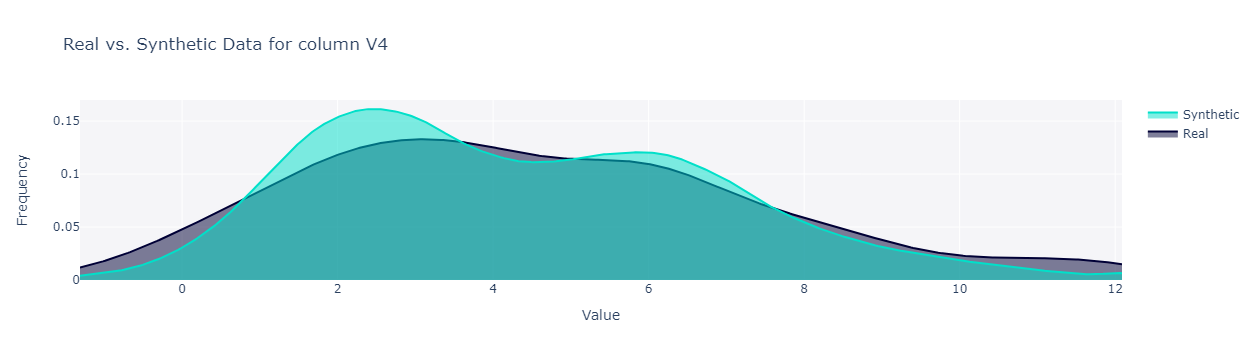

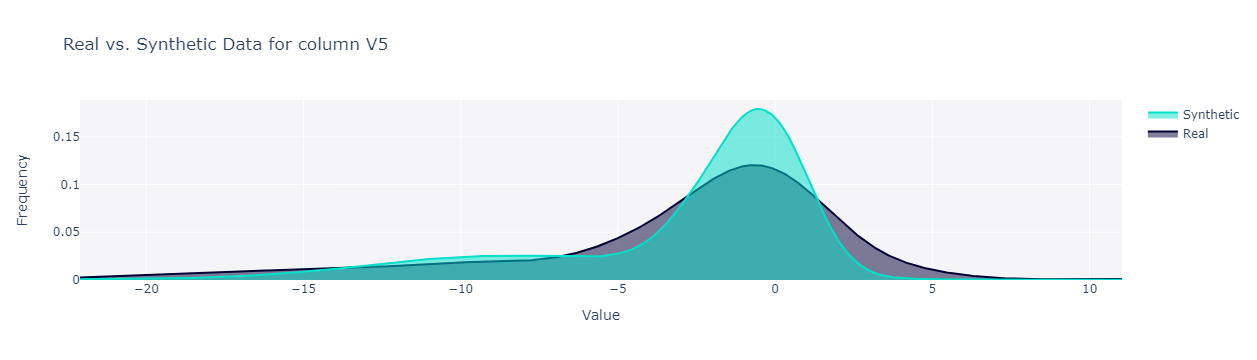

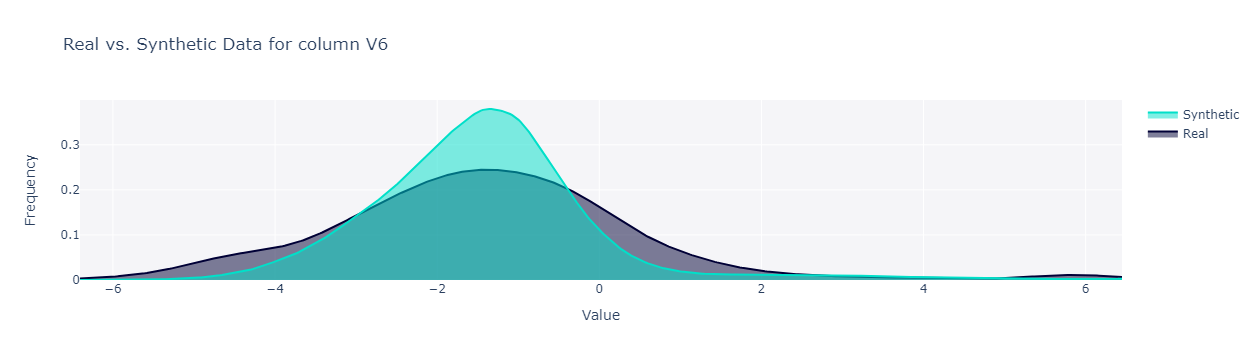

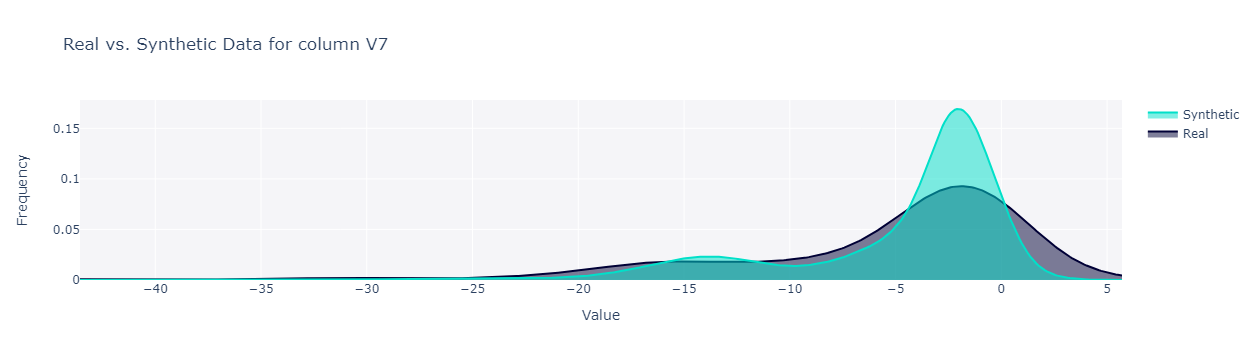

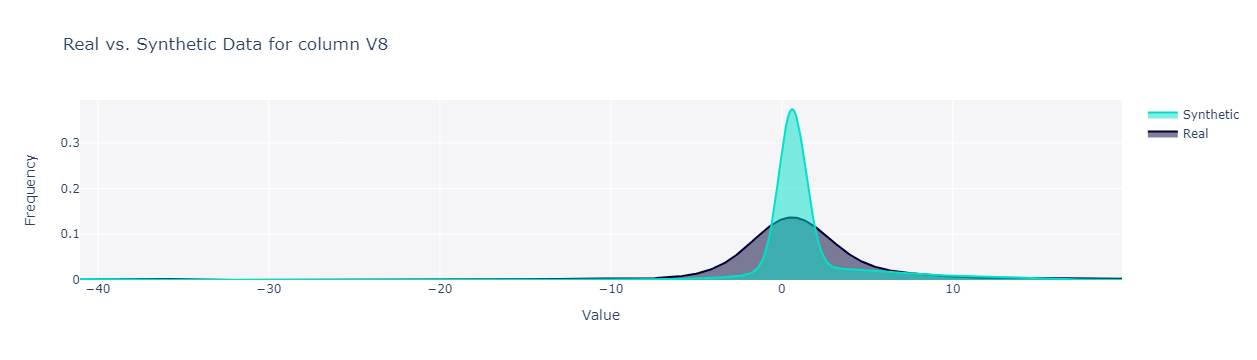

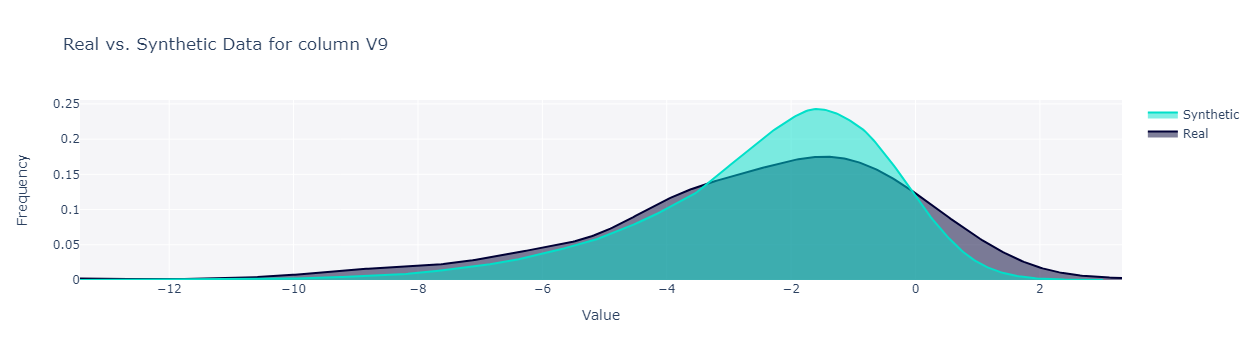

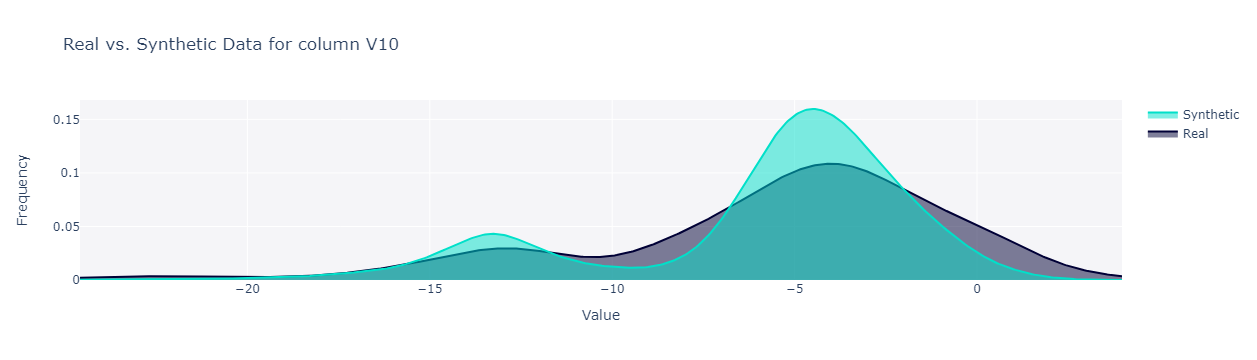

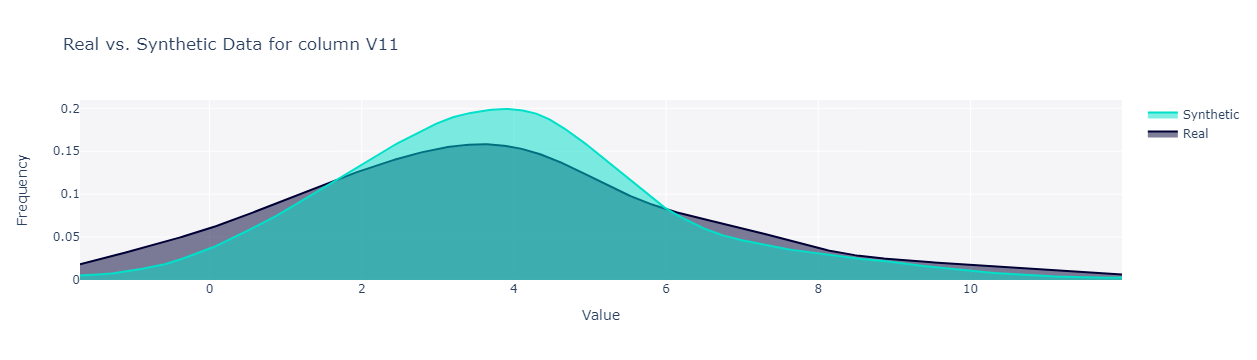

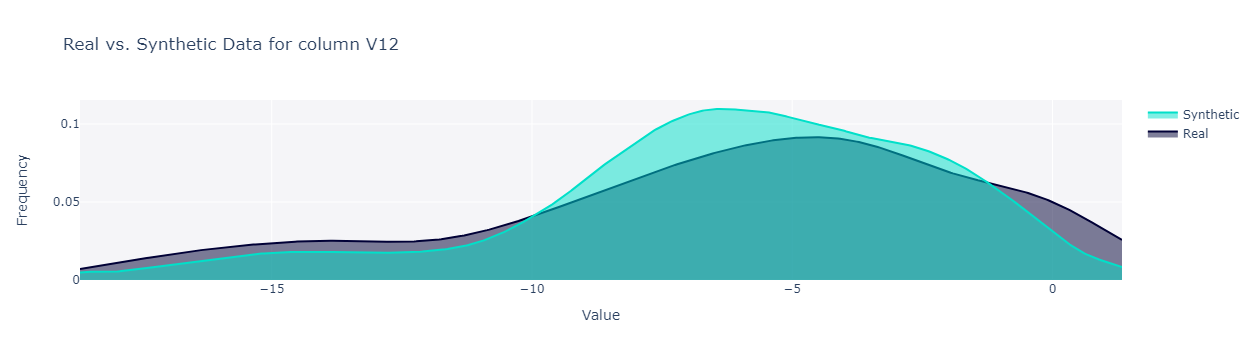

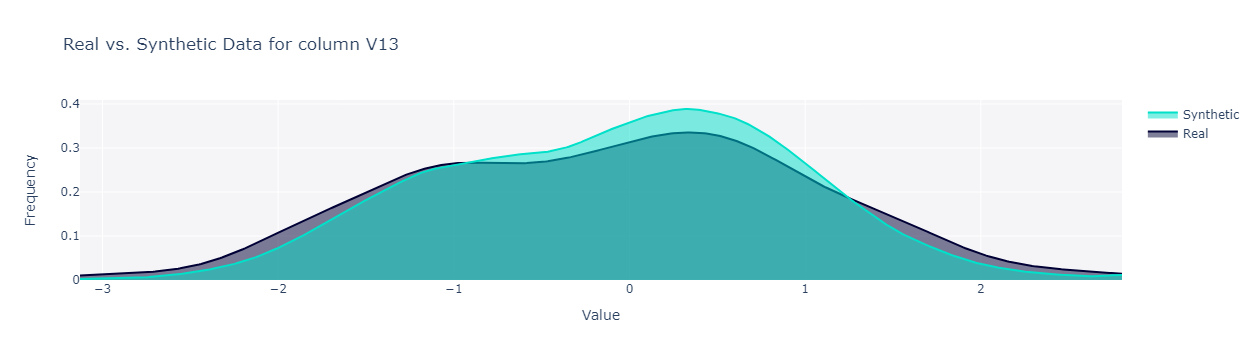

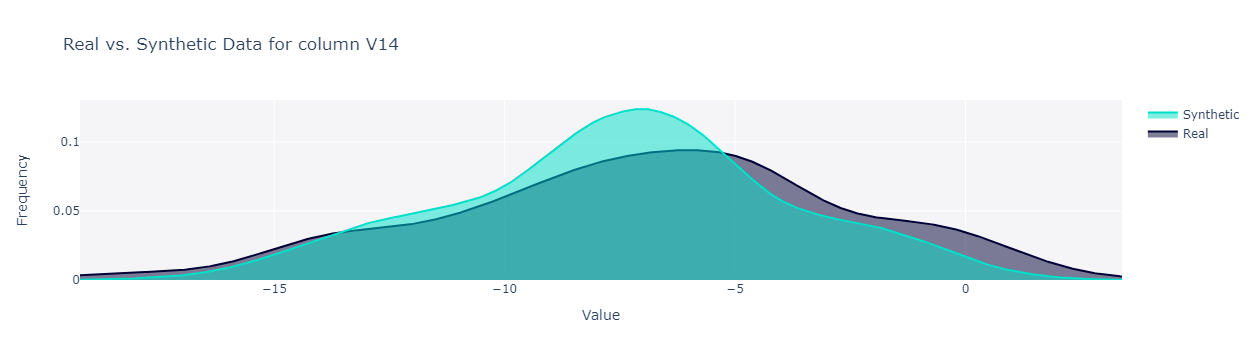

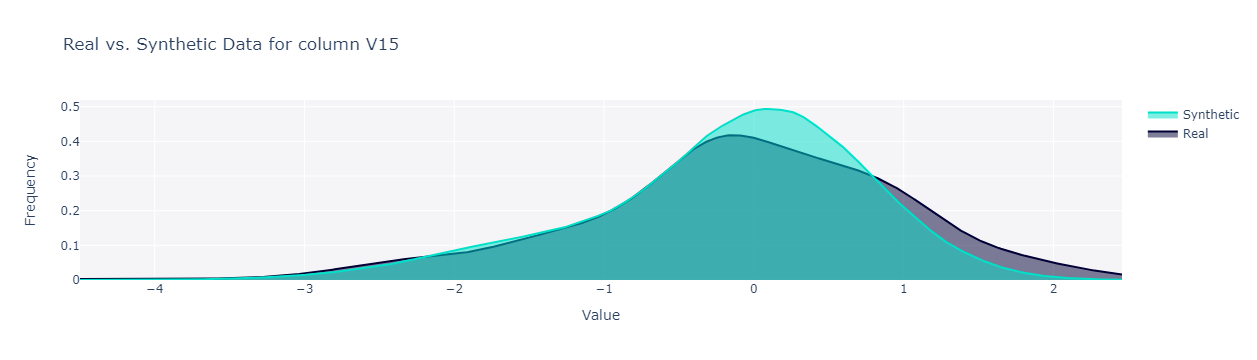

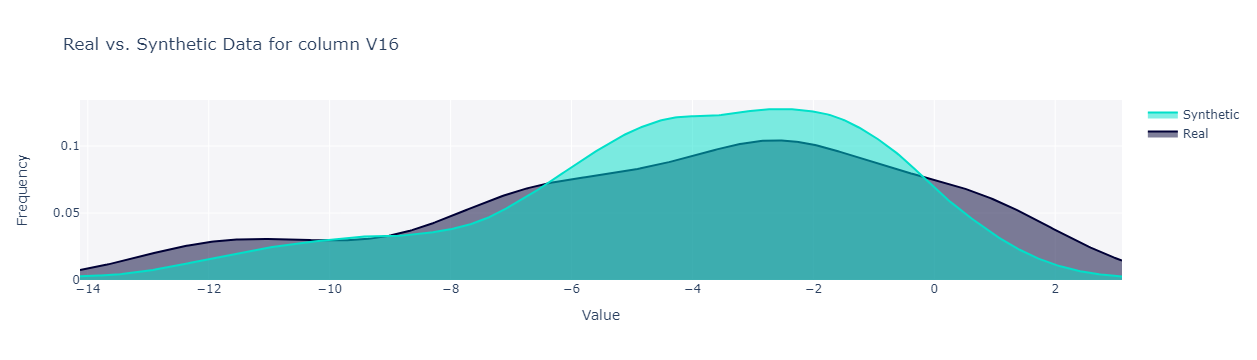

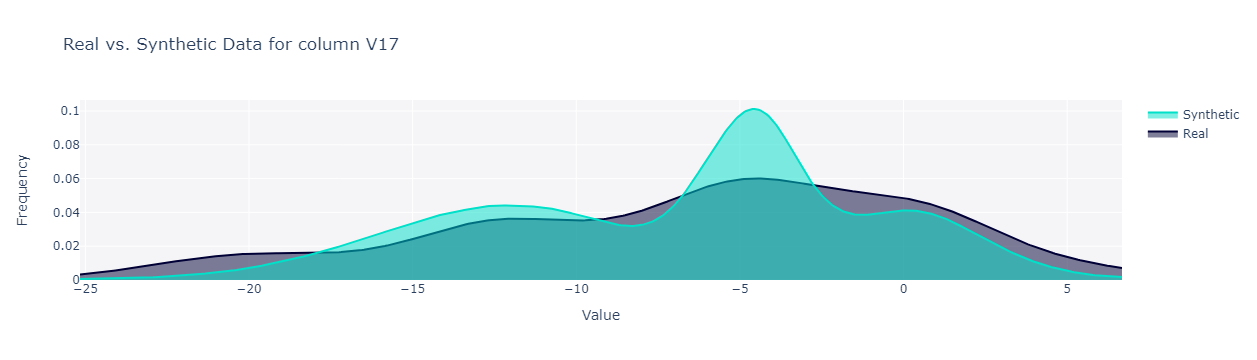

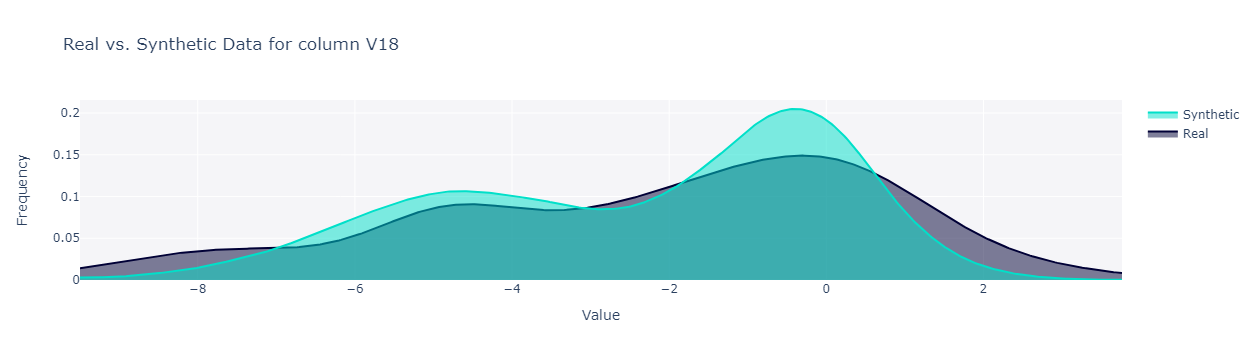

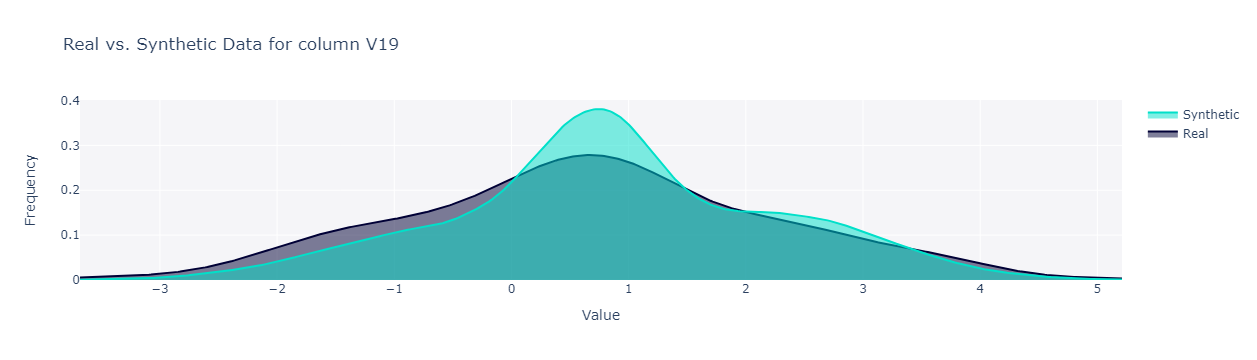

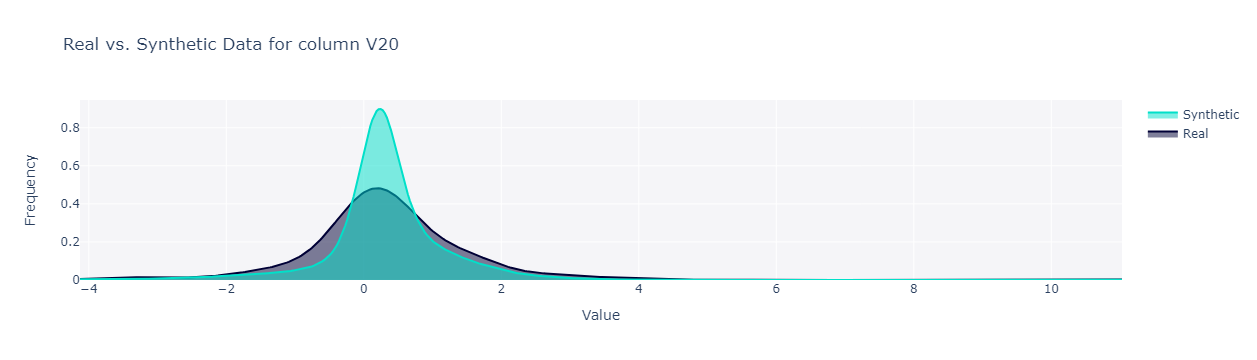

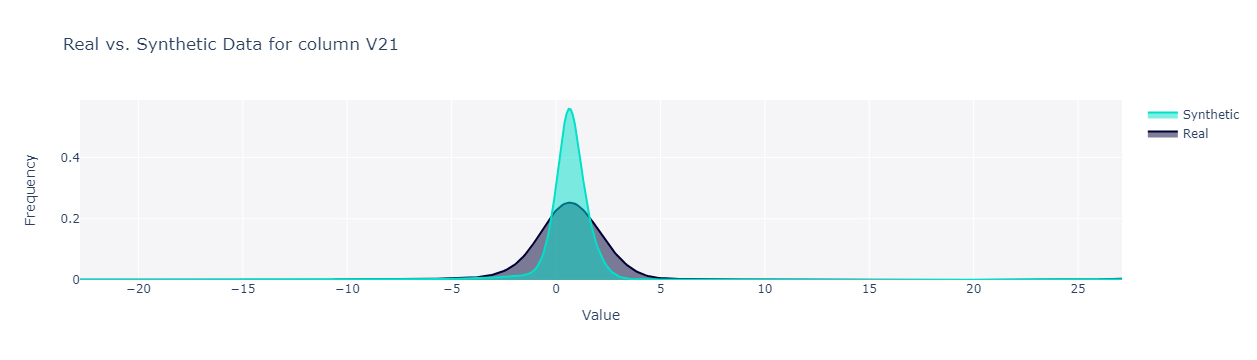

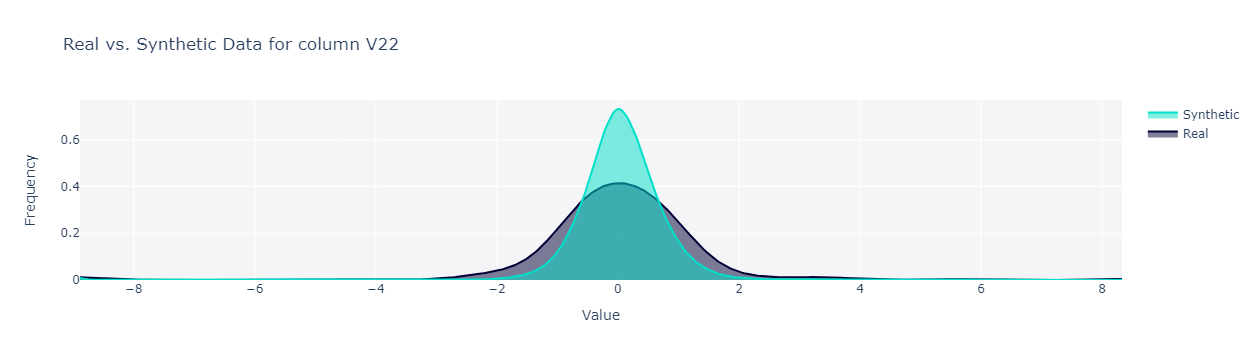

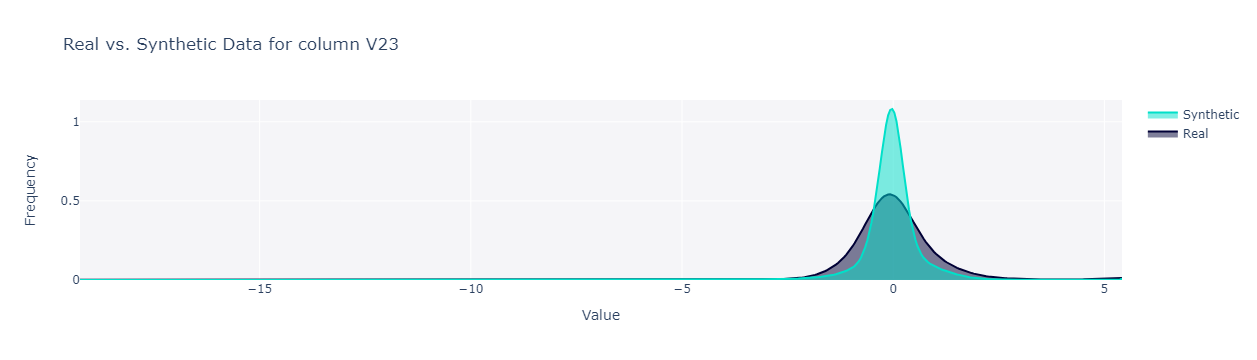

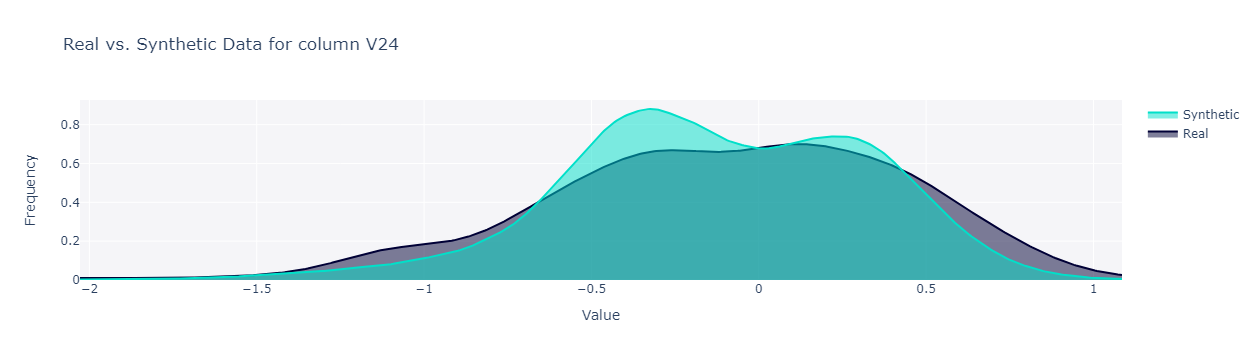

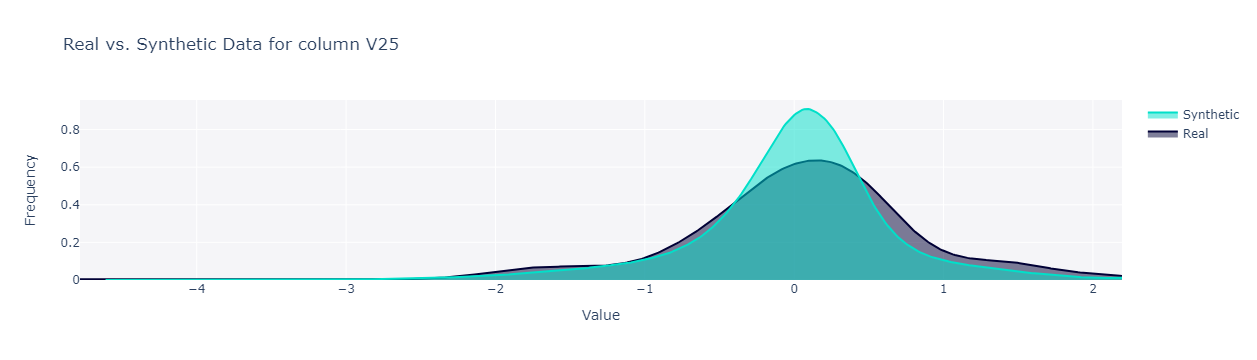

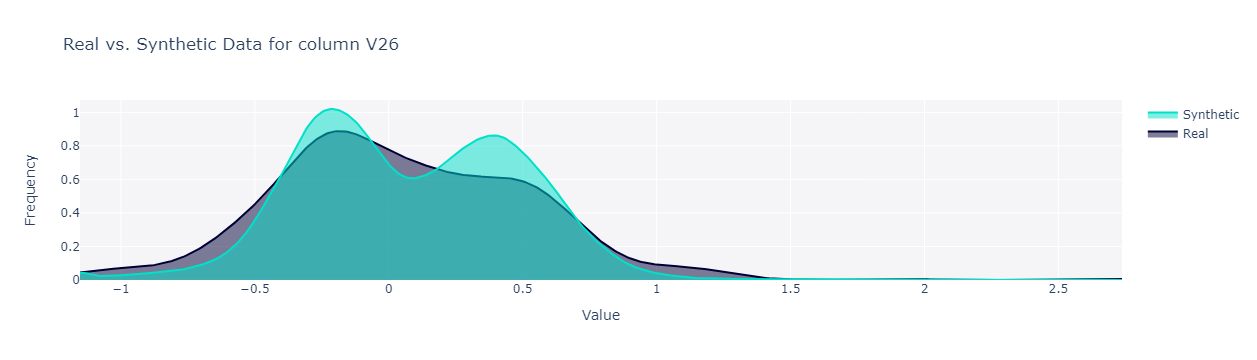

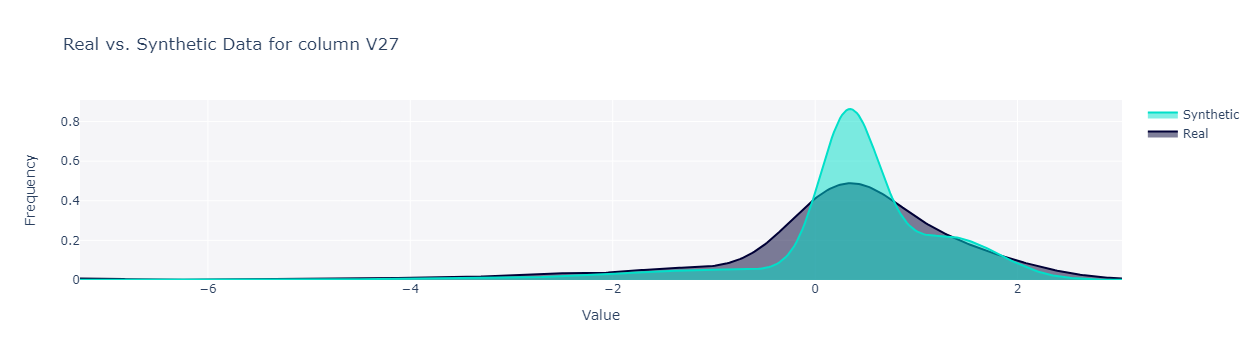

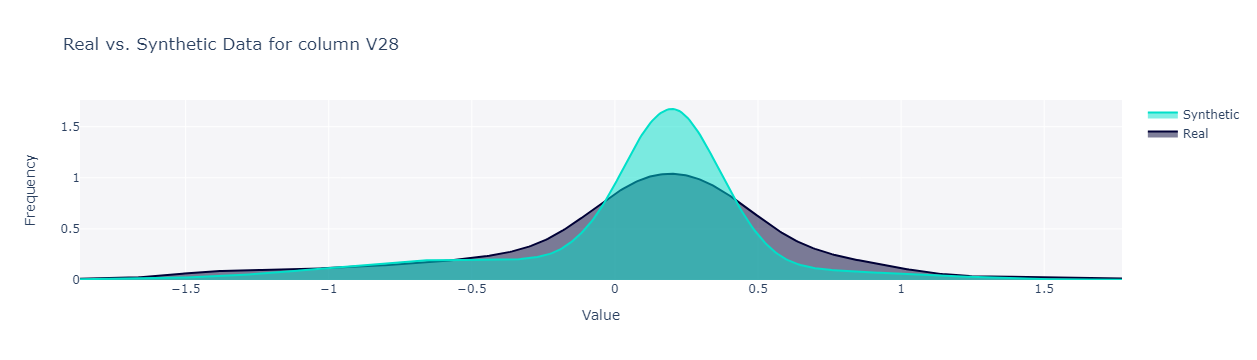

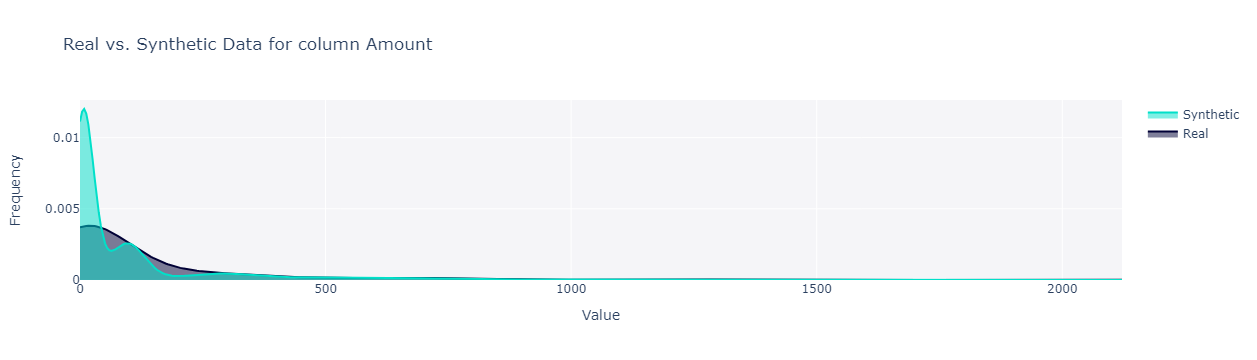

In [55]:
cols_list = df.columns[:-2]

real_data = df_fraud
quality_check(real_data, synthetic_data)

for column_name in cols_list:
    plot_dists(real_data, synthetic_data, column_name)

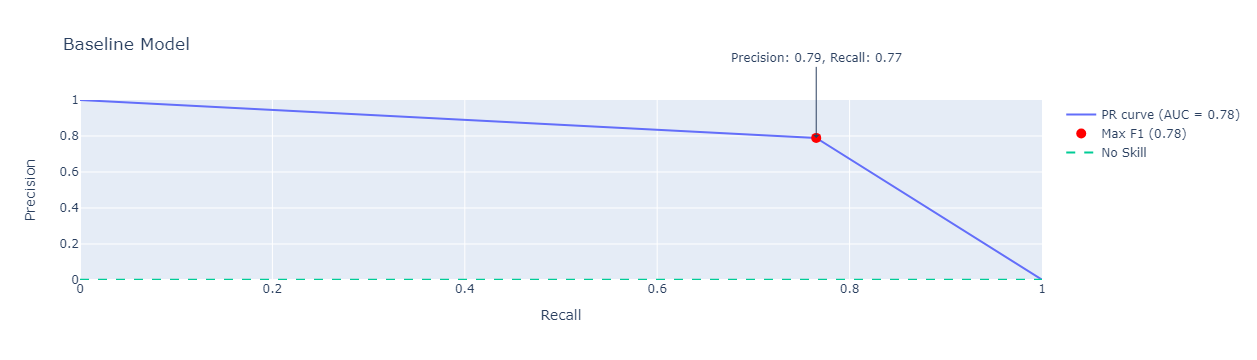

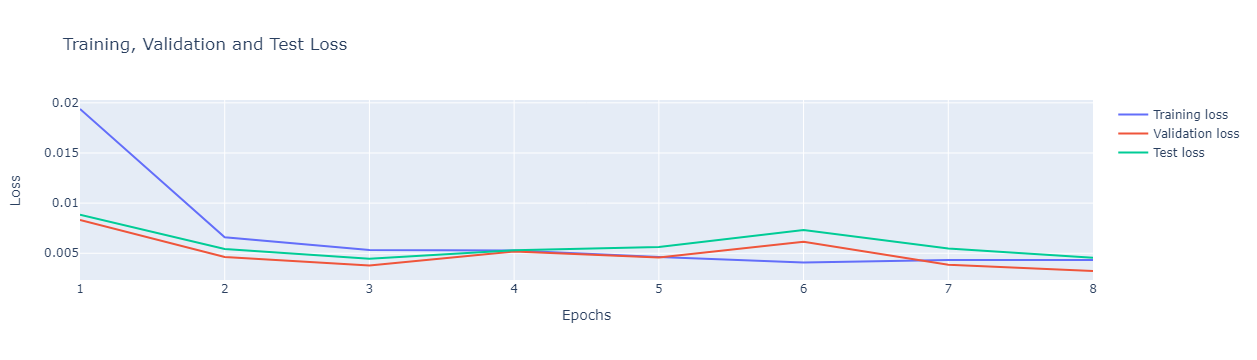

In [56]:
model_url = 'https://raw.githubusercontent.com/john-adeojo/Credit-Card-Fraud-Model-Registry/main/model%20yaml%20files/synthetic_data/baseline_model.yaml'
output_dir = r"..\modelruns"
train_df = train
model = run_experiment(url=model_url, train_df=train_df, output_dir=output_dir)
model_analysis_df = analysis(model, holdout_df)
model_diagnostics(model_analysis_df, title="Baseline Model")
plot_loss(output_dir)
delete_file()

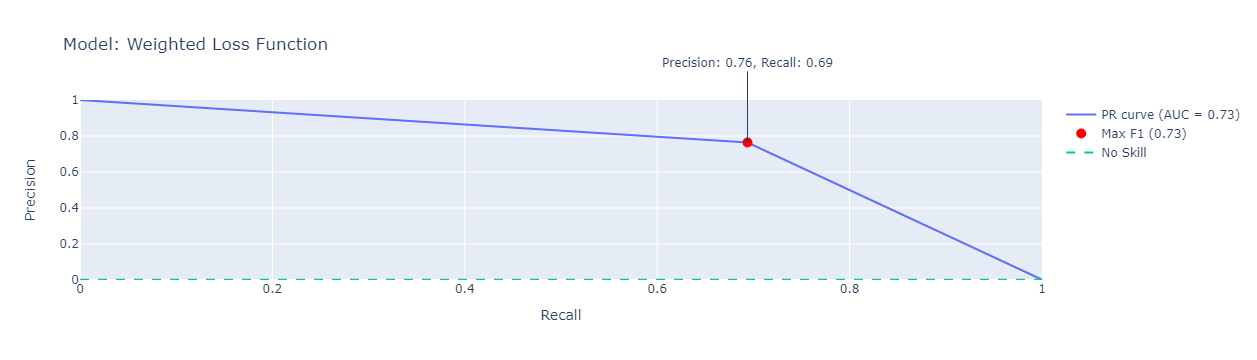

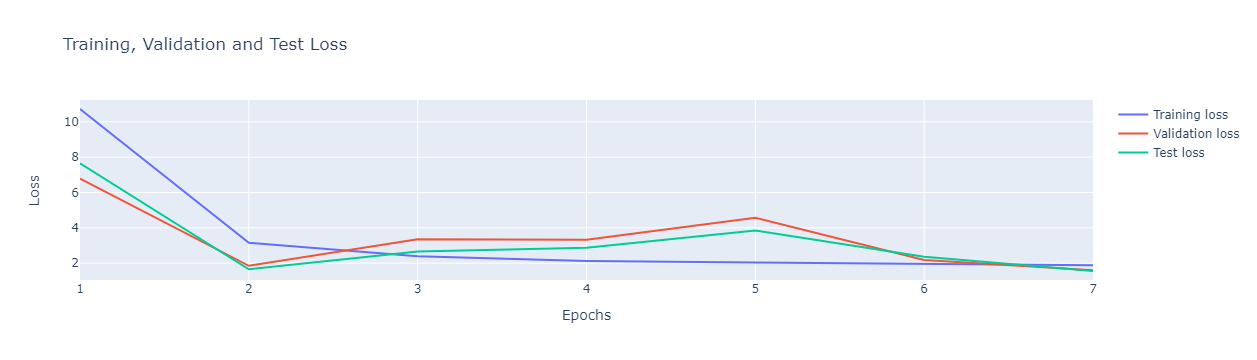

In [57]:
model_url = 'https://raw.githubusercontent.com/john-adeojo/Credit-Card-Fraud-Model-Registry/main/model%20yaml%20files/synthetic_data/model_weighted_loss.yaml'
train_df = train
model = run_experiment(url=model_url, train_df=train_df, output_dir=output_dir)
model_analysis_df = analysis(model, holdout_df)
model_diagnostics(model_analysis_df, title="Model: Weighted Loss Function")
plot_loss(output_dir)
delete_file()

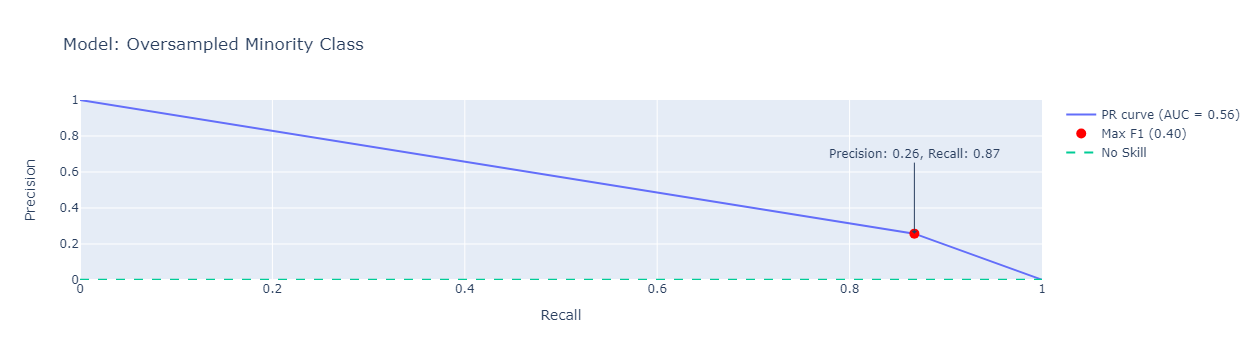

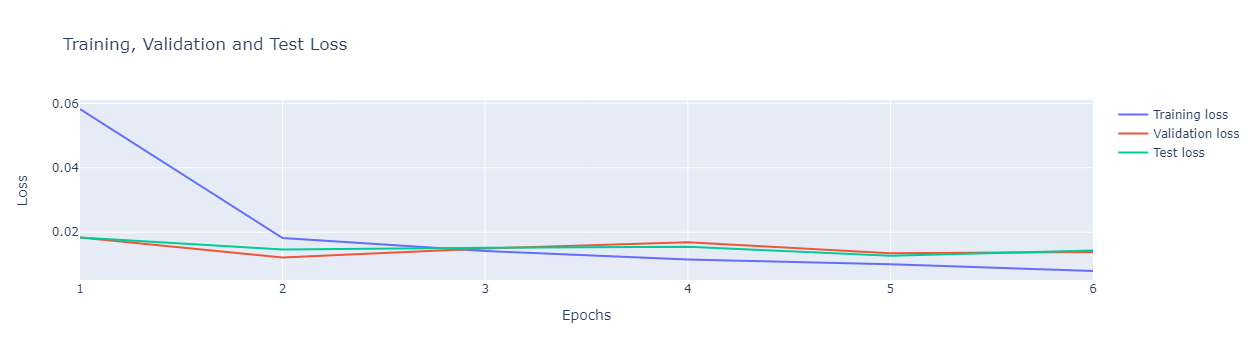

In [58]:
model_url = 'https://raw.githubusercontent.com/john-adeojo/Credit-Card-Fraud-Model-Registry/main/model%20yaml%20files/synthetic_data/model_oversample.yaml'
train_df = train
model = run_experiment(url=model_url, train_df=train_df, output_dir=output_dir)
model_analysis_df = analysis(model, holdout_df)
model_diagnostics(model_analysis_df, title="Model: Oversampled Minority Class")
plot_loss(output_dir)
delete_file()

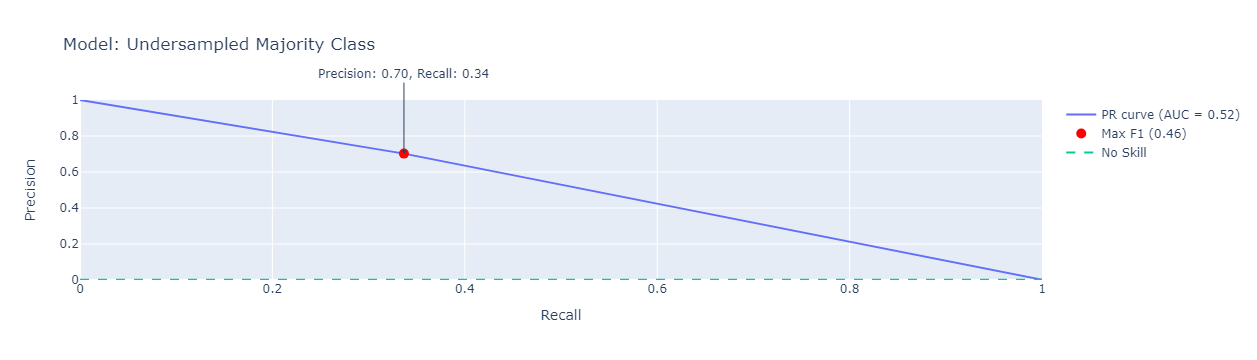

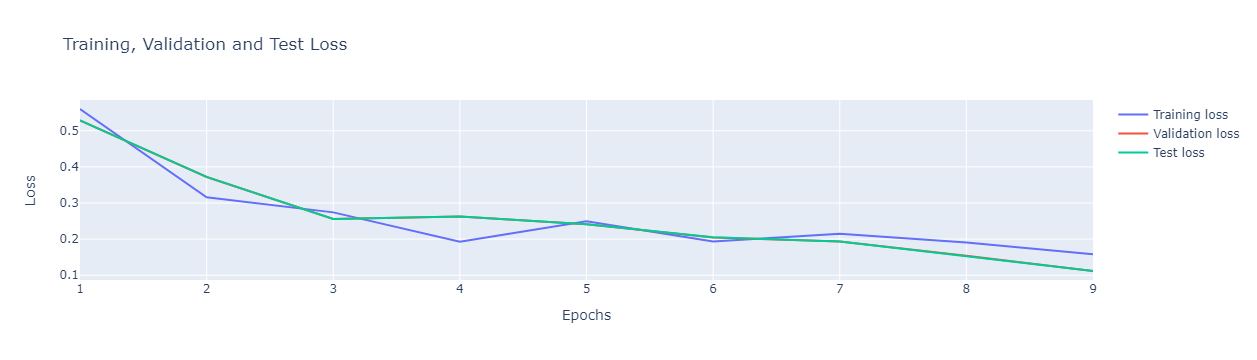

In [59]:
model_url = 'https://raw.githubusercontent.com/john-adeojo/Credit-Card-Fraud-Model-Registry/main/model%20yaml%20files/synthetic_data/model_undersample.yaml'
train_df = train
model = run_experiment(url=model_url, train_df=train_df, output_dir=output_dir)
model_analysis_df = analysis(model, holdout_df)
model_diagnostics(model_analysis_df, title="Model: Undersampled Majority Class")
plot_loss(output_dir)
delete_file()

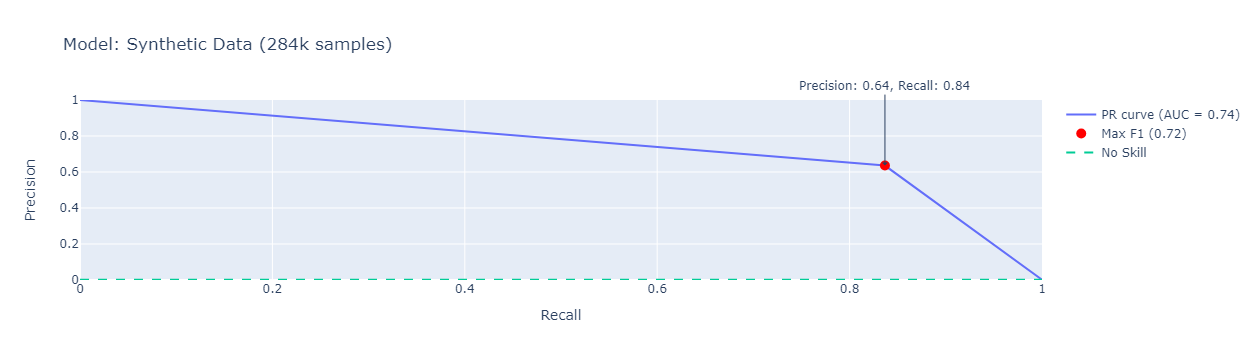

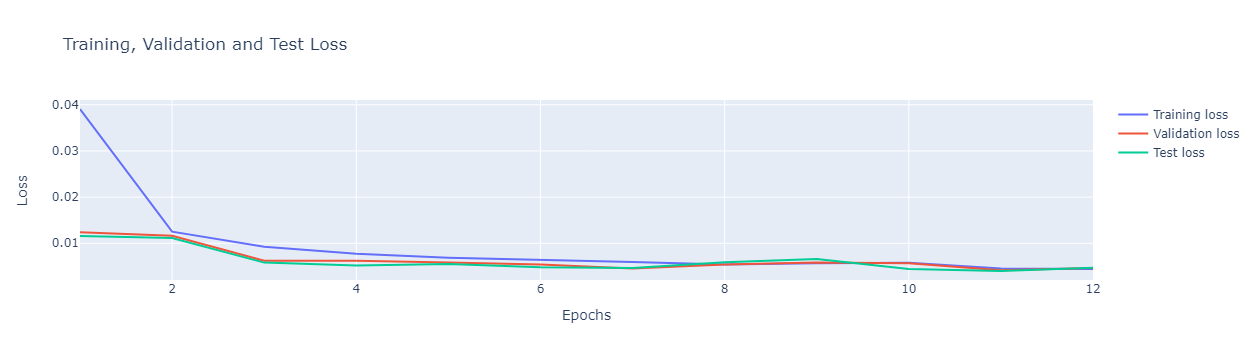

In [60]:
model_url = 'https://raw.githubusercontent.com/john-adeojo/Credit-Card-Fraud-Model-Registry/main/model%20yaml%20files/synthetic_data/baseline_model.yaml'
train_df = train_with_synth
model = run_experiment(url=model_url, train_df=train_df, output_dir=output_dir)
model_analysis_df = analysis(model, holdout_df)
model_diagnostics(model_analysis_df, title="Model: Synthetic Data (284k samples)")
plot_loss(output_dir)
delete_file()

In [67]:
# Load the Ludwig model 

model_baseline = LudwigModel.load(r"C:\Users\johna\anaconda3\envs\synth-env\synthetic_data_credit_cards\modelruns\experiment_run_7\model")
model_weight = LudwigModel.load(r"C:\Users\johna\anaconda3\envs\synth-env\synthetic_data_credit_cards\modelruns\experiment_run_8\model")
model_synth = LudwigModel.load(r"C:\Users\johna\anaconda3\envs\synth-env\synthetic_data_credit_cards\modelruns\experiment_run_11\model")
model_oversample = LudwigModel.load(r"C:\Users\johna\anaconda3\envs\synth-env\synthetic_data_credit_cards\modelruns\experiment_run_9\model")
model_undersample = LudwigModel.load(r"C:\Users\johna\anaconda3\envs\synth-env\synthetic_data_credit_cards\modelruns\experiment_run_10\model")



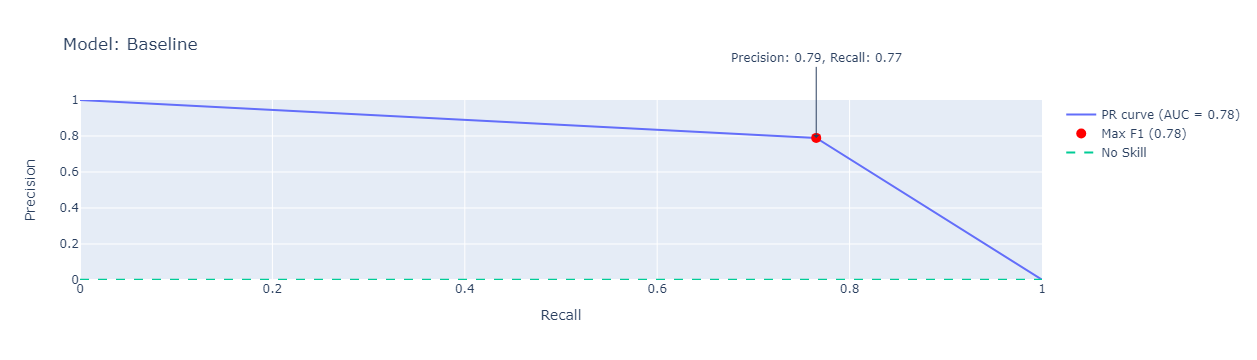

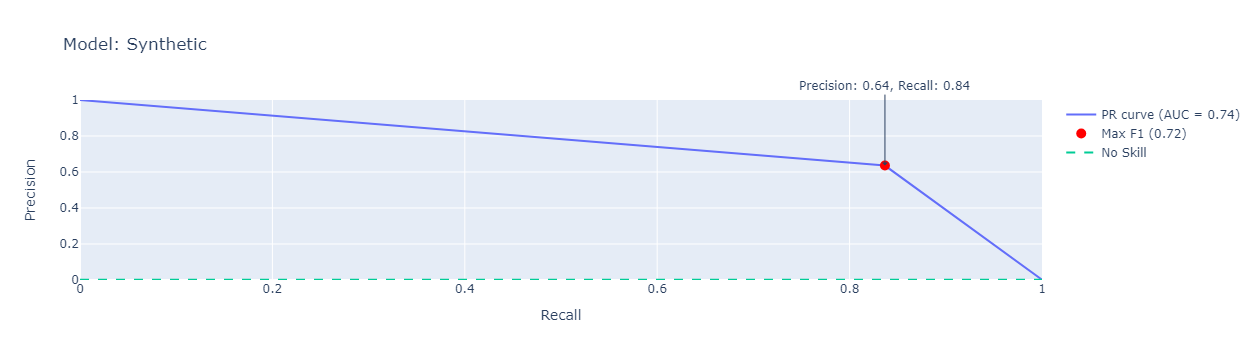

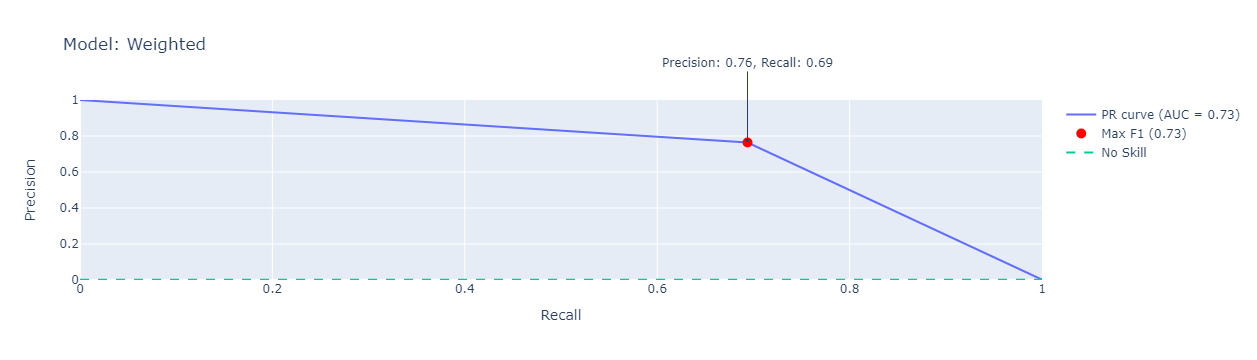

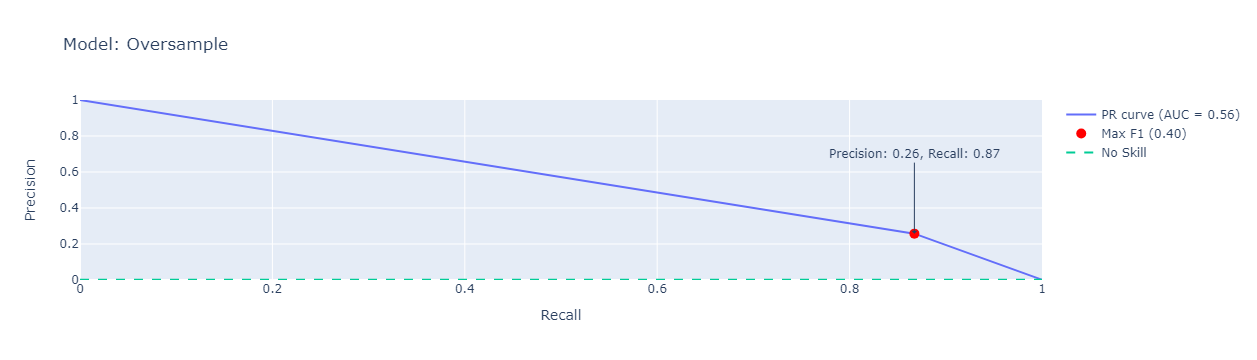

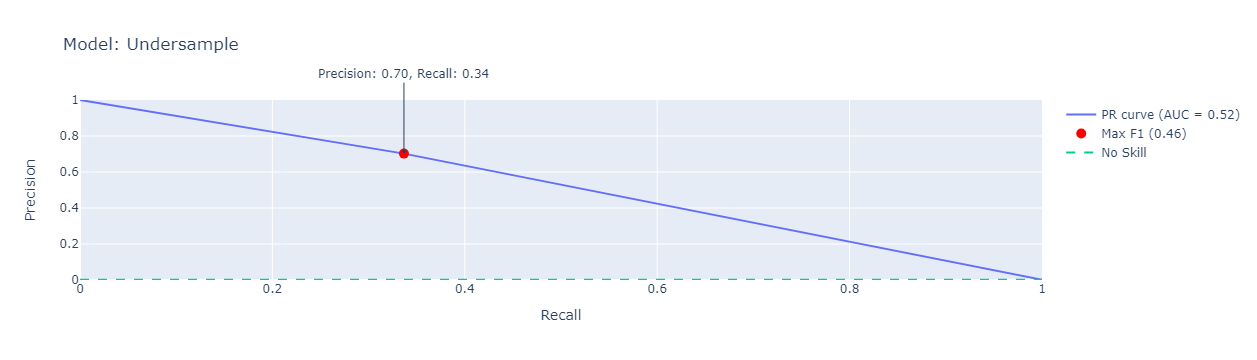

(0.5200017325351455, 0.4551724137931034, 0.7021276595744681, 0.336734693877551)

In [68]:

# check models
model_analysis__baseline = analysis(model=model_baseline, holdout_df=holdout_df)
model_analysis__synth =  analysis(model=model_synth, holdout_df=holdout_df)
model_analysis__weight =  analysis(model=model_weight, holdout_df=holdout_df)
model_analysis__oversample =  analysis(model=model_oversample, holdout_df=holdout_df)
model_analysis__undersample =  analysis(model=model_undersample, holdout_df=holdout_df)


model_diagnostics(model_analysis__baseline, title="Model: Baseline")
model_diagnostics(model_analysis__synth, title="Model: Synthetic")
model_diagnostics(model_analysis__weight, title="Model: Weighted")
model_diagnostics(model_analysis__oversample, title="Model: Oversample")
model_diagnostics(model_analysis__undersample, title="Model: Undersample")




In [63]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from sklearn.metrics import precision_recall_curve, auc, precision_score, recall_score
import scipy.stats as stats

def bootstrap_analysis(model, holdout_df, n_iterations=1000):
    # Store metrics results
    pr_auc_scores = []
    precision_scores = []
    recall_scores = []
    
    # Bootstrap sampling and prediction
    for i in range(n_iterations):
        sample = resample(holdout_df, replace=True)
        model_analysis_df = analysis(model, sample)

        # Calculate metrics
        precision, recall, _ = precision_recall_curve(model_analysis_df['Class'], model_analysis_df['Class_predictions'])
        pr_auc = auc(recall, precision)
        pr_auc_scores.append(pr_auc)
        
        precision = precision_score(model_analysis_df['Class'], model_analysis_df['Class_predictions'])
        precision_scores.append(precision)

        recall = recall_score(model_analysis_df['Class'], model_analysis_df['Class_predictions'])
        recall_scores.append(recall)
        
    return pr_auc_scores, precision_scores, recall_scores

def compare_models(model1, model2, model1_name, model2_name, holdout_df, n_iterations=50):
    pr_auc_scores1, precision_scores1, recall_scores1 = bootstrap_analysis(model1, holdout_df, n_iterations)
    pr_auc_scores2, precision_scores2, recall_scores2 = bootstrap_analysis(model2, holdout_df, n_iterations)

    # Plotting
    metrics = ['AUC-PR', 'Precision', 'Recall']
    model1_scores = [pr_auc_scores1, precision_scores1, recall_scores1]
    model2_scores = [pr_auc_scores2, precision_scores2, recall_scores2]
    
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    for i, ax in enumerate(axs):
        sns.kdeplot(model1_scores[i], ax=ax, shade=True, label=model1_name)
        sns.kdeplot(model2_scores[i], ax=ax, shade=True, label=model2_name)
        ax.set_title(metrics[i])
        
        # Compute and display KS statistic
        ks_stat, ks_p_value = stats.ks_2samp(model1_scores[i], model2_scores[i])
        print(f'KS statistic for {metrics[i]}: {ks_stat:.3f}, p-value: {ks_p_value:.3f}')
        
        ax.legend()
    plt.show()

KS statistic for AUC-PR: 0.520, p-value: 0.000
KS statistic for Precision: 0.960, p-value: 0.000
KS statistic for Recall: 0.640, p-value: 0.000


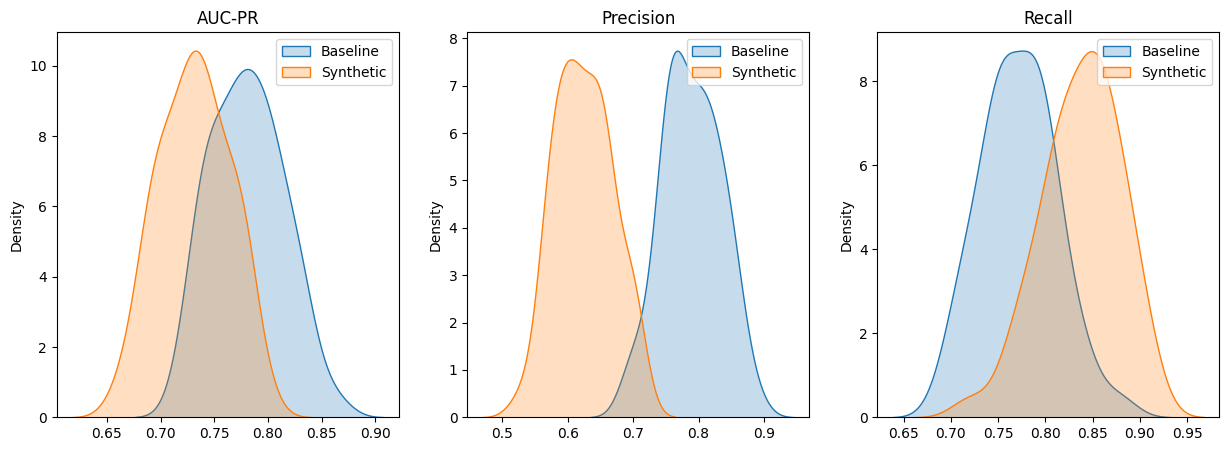

In [64]:
# Now you can call compare_models
model1_name = "Baseline"
model2_name = "Synthetic"

compare_models(model_baseline, model_synth, model1_name, model2_name, holdout_df)

KS statistic for AUC-PR: 0.440, p-value: 0.000
KS statistic for Precision: 0.260, p-value: 0.068
KS statistic for Recall: 0.520, p-value: 0.000


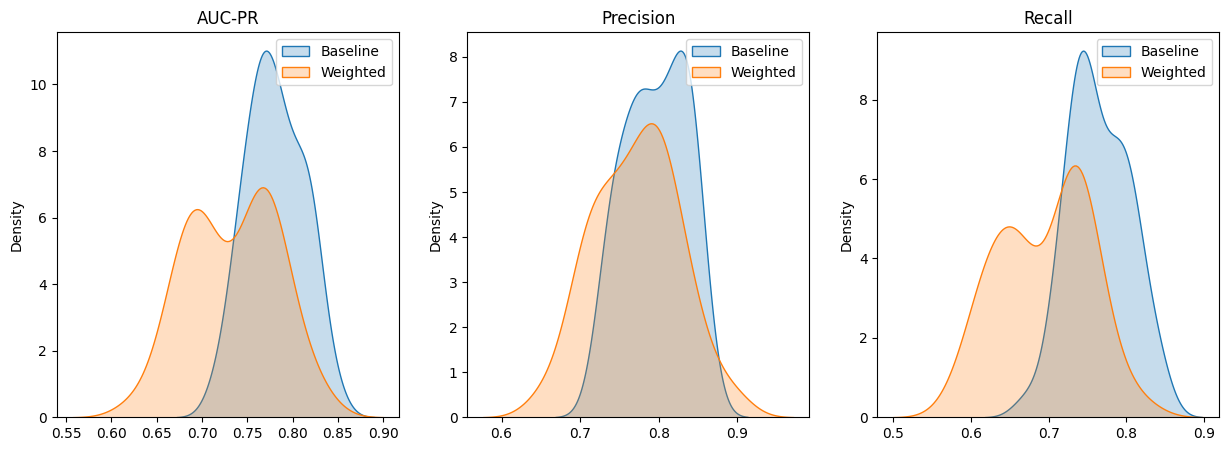

In [65]:
model2_name = "Weighted"
compare_models(model_baseline, model_weight, model1_name, model2_name, holdout_df)


KS statistic for AUC-PR: 1.000, p-value: 0.000
KS statistic for Precision: 1.000, p-value: 0.000
KS statistic for Recall: 0.800, p-value: 0.000


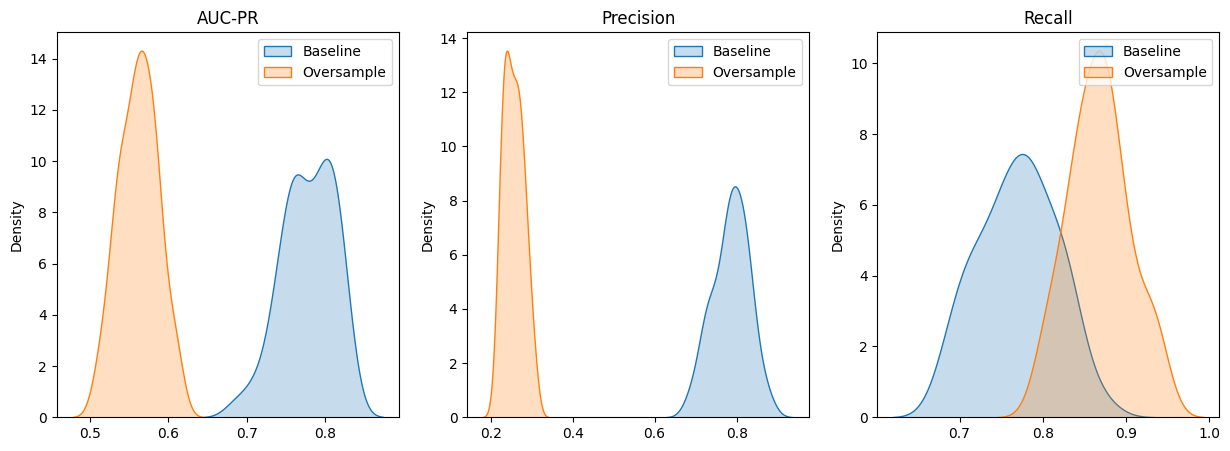

In [71]:
model2_name = "Oversample"
compare_models(model_baseline, model_oversample, model1_name, model2_name, holdout_df)

In [ ]:
model2_name = "Undersample"
compare_models(model_baseline, model_undersample, model1_name, model2_name, holdout_df)